In [1]:
!pip install transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv" , index_col = 0)  # Must have 'text' and 'label' columns
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [4]:
data.rename(columns={'label':'labels'},inplace=True)

data.head()

,title,text,labels
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


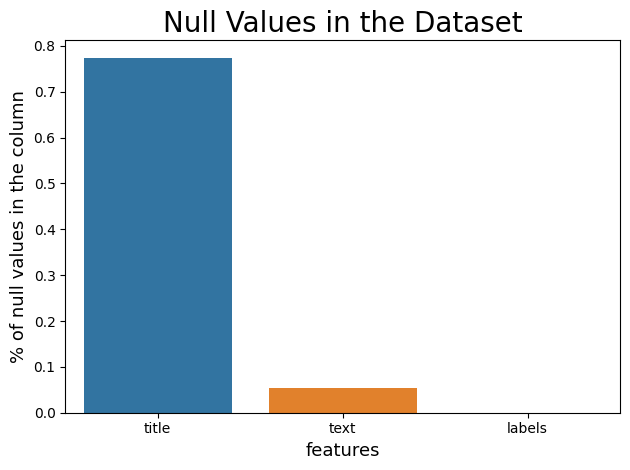

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')
    
    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')  

In [6]:
data.dropna(axis=0,inplace=True)

In [7]:
data.drop_duplicates(inplace=True)

data.shape

(63121, 3)

In [8]:
data = data.sample(frac=1,random_state=42) 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


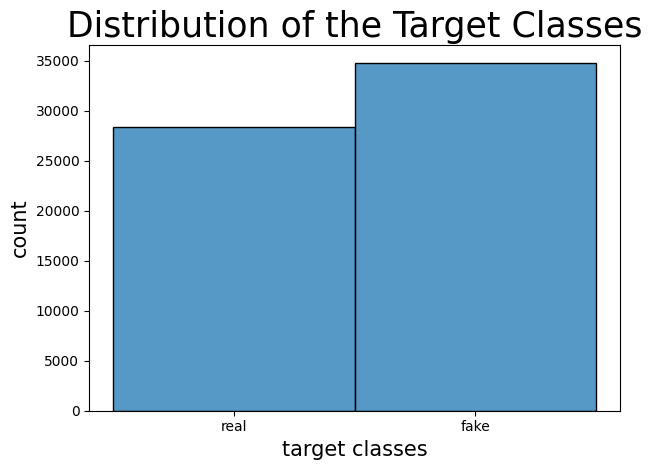

In [9]:
# Creating a column with 'readable' labels for the news

news_map = {1:'real',0:'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


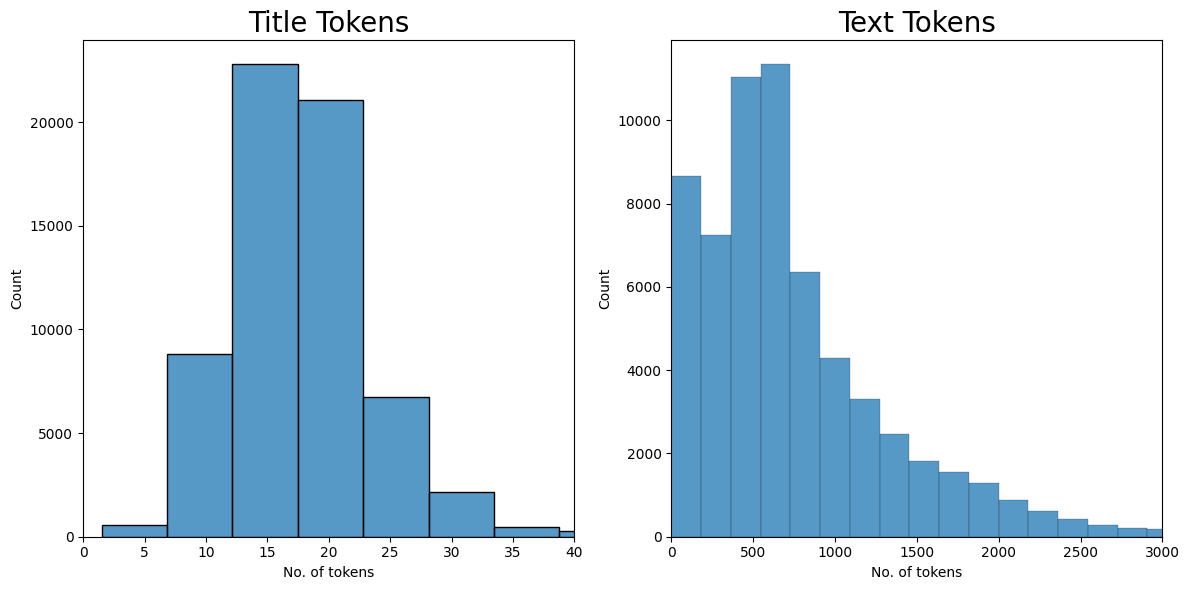

In [10]:
####################################
# In general one has 1.5 tokens per word on average
title_tokens = data['title'].apply(lambda x: len(x.split())*1.5)
text_tokens  = data['text'].apply(lambda x: len(x.split())*1.5)
####################################

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1 = sns.histplot(title_tokens,ax=ax1,bins=20)
ax1.set_xlabel('No. of tokens')
ax1.set_title("Title Tokens",fontsize=20)
ax1.set_xlim(0,40)

ax2 = sns.histplot(text_tokens,ax=ax2,bins=200)
ax2.set_xlabel('No. of tokens')
ax2.set_title("Text Tokens",fontsize=20)
ax2.set_xlim(0,3000)

plt.tight_layout()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


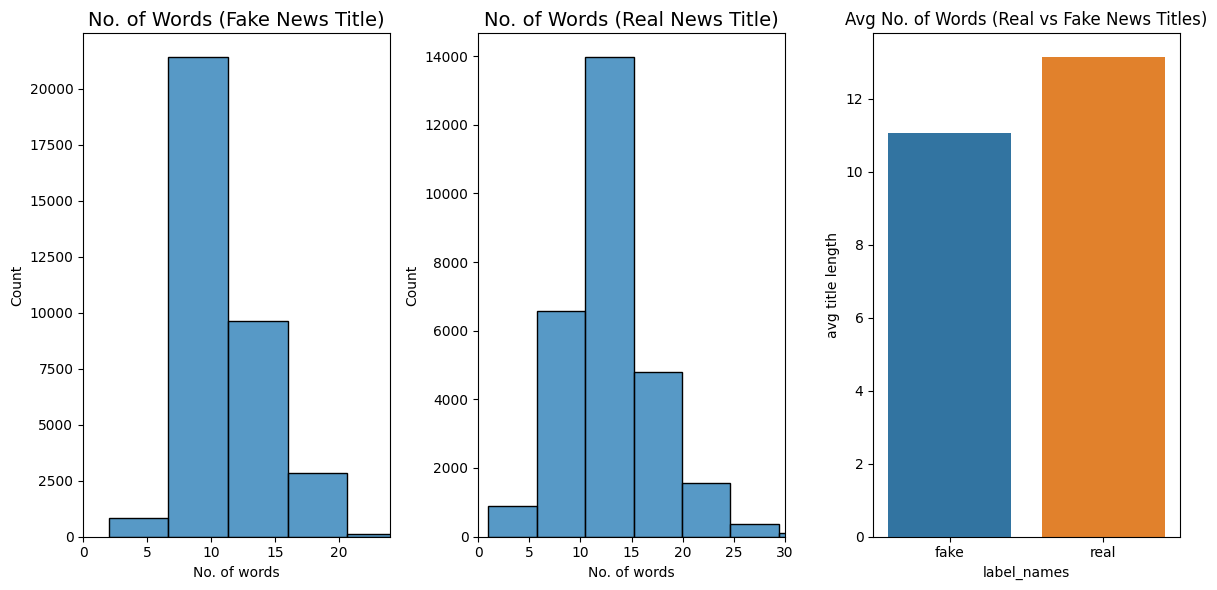

In [11]:
##########################
fake_title = data.loc[data.labels == 0]['title'].apply(lambda x: len(x.split()))
real_title = data.loc[data.labels == 1]['title'].apply(lambda x: len(x.split()))

data['title_length'] = data['title'].apply(lambda x: len(x.split()))

avg_title = data.groupby('label_names')['title_length'].mean().reset_index(name='avg title length')
##########################

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(fake_title,ax=ax1,bins=6)
ax1.set_xlim(0,24)
ax1.set_xlabel('No. of words')
ax1.set_title("No. of Words (Fake News Title)",fontsize=14)

ax2 = sns.histplot(real_title,ax=ax2,bins=15)
ax2.set_xlim(0,30)
ax2.set_xlabel('No. of words')
ax2.set_title("No. of Words (Real News Title)",fontsize=14)

ax3 = sns.barplot(data=avg_title,x='label_names',y='avg title length')
ax3.set_title("Avg No. of Words (Real vs Fake News Titles)",fontsize=12)

plt.tight_layout()

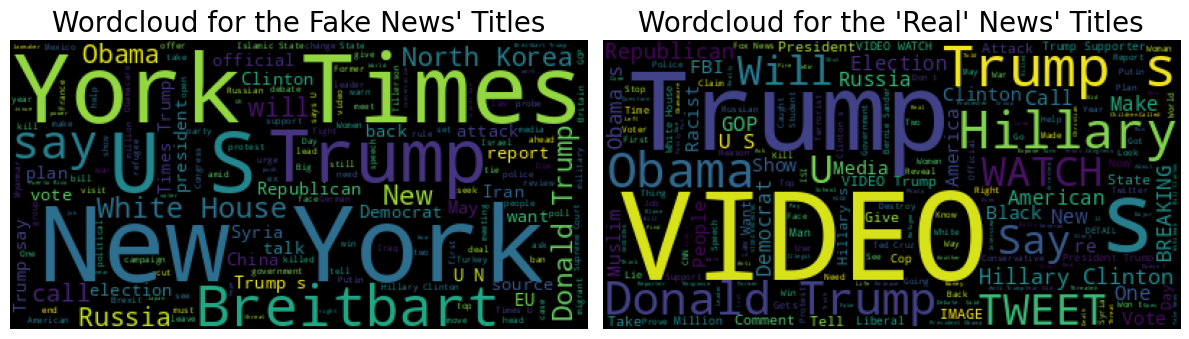

In [12]:
from wordcloud import WordCloud
text_fake = ' '.join(data.loc[data.labels == 0]['title'])
text_real = ' '.join(data.loc[data.labels == 1]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()


In [13]:
data3 = data.copy()

In [14]:
data3.head()

,title,text,labels,label_names,title_length
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1,real,16
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1,real,1
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0,fake,8
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0,fake,9
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1,real,14


In [15]:
data3.drop(columns=['label_names','title_length'],axis=1,inplace=True)

In [16]:
data3["merged"] = data3['title']+''+data3['text'] 

In [17]:
data3.head()

,title,text,labels,merged
71361,Donald Trump Responds To Mockery Over Fake Sw...,"Last night, at a rally in Melbourne, Florida, ...",1,Donald Trump Responds To Mockery Over Fake Sw...
11496,Tweetwave,This time it's true no pantsTweetwave More Of ...,1,TweetwaveThis time it's true no pantsTweetwave...
20292,Rubio says prospect of Trump president is 'wor...,(Reuters) - U.S. Senator Marco Rubio said on W...,0,Rubio says prospect of Trump president is 'wor...
38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0,Trump lifts Cyber Command status to boost cybe...
20416,The 7 Biggest Republican Lies About The Econo...,"In two-and-a-half minutes, former U.S. Secreta...",1,The 7 Biggest Republican Lies About The Econo...


In [18]:
data3.drop(columns = ['title' , 'text'] , inplace = True)

In [19]:
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
import string


def clean_text(text):

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

In [20]:
data3["merged"] = data3["merged"].apply(clean_text)

In [21]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data3['merged'].tolist(), data3['labels'].tolist(), test_size=0.2, random_state=42
)

In [22]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
import torch

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)


In [24]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    do_eval = True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


2025-04-12 06:47:17.962730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744440438.153474      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744440438.213539      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [25]:
trainer.train()


Step,Training Loss
500,0.269700
1000,0.107100
1500,0.070800
2000,0.061900
2500,0.061700
3000,0.054000
3500,0.027500
4000,0.029200
4500,0.025700
5000,0.023500


TrainOutput(global_step=9468, training_loss=0.043592336261428555, metrics={'train_runtime': 4864.0643, 'train_samples_per_second': 31.144, 'train_steps_per_second': 1.947, 'total_flos': 2.006722128760013e+16, 'train_loss': 0.043592336261428555, 'epoch': 3.0})

In [26]:
eval_result = trainer.evaluate()
print(eval_result)


{'eval_loss': 0.040713369846343994, 'eval_runtime': 101.4058, 'eval_samples_per_second': 124.5, 'eval_steps_per_second': 1.953, 'epoch': 3.0}


In [27]:
preds = trainer.predict(val_dataset)
pred_labels = preds.predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(val_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6991
           1       0.99      0.99      0.99      5634

    accuracy                           0.99     12625
   macro avg       0.99      0.99      0.99     12625
weighted avg       0.99      0.99      0.99     12625

